# Project Part II: Predicting Housing Prices - Build Your Own Model

 

### Grading Scheme

Your grade for the project will be based on your training RMSE and test RMSE. The thresholds are as follows:

Points | 9 | 7 | 5 | 3
--- | --- | --- | --- | ---
Training RMSE | Less than 60k | [60k, 120k) | [120k, 200k) | More than 230k

Points | 9 | 7 | 5 | 3
--- | --- | --- | --- | ---
Test RMSE | Less than 65k | [65k, 130k) | [130k, 230k) | More than 230k

The top 20% of the submissions with the least testing errors will receive the additional two points


In [1]:
# Some Imports You Might Need
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model as lm

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# Extract Dataset
with zipfile.ZipFile('cook_county_contest_data.zip') as item:
    item.extractall()
    
    
### Note: we filtered the data in cook_county_contest_data, 
####so please use this dataset instead of the old one.

### Note

This notebook is specifically designed to guide you through the process of exporting your model's predictions on the test dataset for submission so you can see how your model performs.

Most of what you have done in project part I should be transferrable here. 

## Step 1. Set up all the helper functions for your `process_data_fm` function.

**Copy-paste all of the helper functions your `process_data_fm` need here in the following cell**. You **do not** have to fill out all of the functions in the cell below -- only fill out those that are actually useful to your feature engineering pipeline.

In [2]:
def add_total_bedrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    with_rooms["Bedrooms"] = with_rooms["Description"].str.split(r"(\d+) of which are bedrooms",expand=True)[1].astype(np.int64)
    with_rooms["Bedrooms"].fillna(0)
    return with_rooms

def add_total_rooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    with_rooms["Rooms"] = with_rooms["Description"].str.split(r"(It has a total of) (\d+) (rooms)",expand=True)[2].astype(np.int64)
    with_rooms["Rooms"].fillna(0)
    return with_rooms

def Log_all(data,*variables):
    data_new = data.copy()
    for x in variables:
        x_new = 'Log '+x
        data_new[x_new] = np.log(data_new[x])
    return data_new   

def replace_zero(data, *variables):
    data_new = data.copy()
    for x in variables:
        data_new[x] = data_new.groupby('Neighborhood Code')[x].transform(lambda x: x.replace([0, np.nan, -np.inf], x.median()))
    return data_new

def replace_nuisance(data,*variables):
    for x in variables:
        idx = data[data[x]==-np.inf].index
        data_new = data.drop(index = idx)
        median = data_new[x].median()
        data[x].replace(-np.inf,median,inplace=True)    
    return data
     
def process_data_gm(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col]).to_numpy()
    y = data.loc[:, prediction_col].to_numpy()
    return X, y

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

In [30]:
from sklearn.preprocessing import OneHotEncoder
def ohe_roof_material(data):
    """
    One-hot-encodes roof material.  New columns are of the form 0x_QUALITY.
    """
    data['Roof Material'].replace({1:'Shingle/Asphalt',2:'Tar&Gravel',3:'Slate',4:'Shake',5:'Tile',6:'Other'},inplace=True)
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit([["Shingle/Asphalt"],["Tar&Gravel"],["Slate"],["Shake"],["Tile"],["Other"]])
    ohe_cols = pd.DataFrame(enc.transform(data[['Roof Material']]).todense(), 
                           columns= enc.get_feature_names(),
                           index = data.index)
    ohe_cols = ohe_cols.rename(columns={'x0_Shingle/Asphalt':'rfm_Shingle/Asphalt','x0_Tar&Gravel':'rfm_Tar&Gravel','x0_Slate':'rfm_Slate',
                             'x0_Shake':'rfm_Shake','x0_Tile':'rfm_Tile','x0_Other':'rfm_Other'})
    data = data.join([ohe_cols])
    return data

def find_expensive_neighborhoods(data, n=3, metric=np.median):
    neighborhoods_price = data.groupby('Log Sale Price').agg(metric).sort_values(by='Log Sale Price',ascending=False).head(n).index
    neighborhoods = data.loc[data['Log Sale Price'].isin(neighborhoods_price)]['Neighborhood Code'].values
    return [int(code) for code in neighborhoods]

def add_in_expensive_neighborhood(data, neighborhoods):
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(neighborhoods).astype('int')
    return data

In [61]:
Feature_test = pd.read_csv('cook_county_contest_train.csv')

In [62]:
# Study the covariance to see the importance of the feature
Feature_test = add_total_bedrooms(Feature_test)
Feature_test = add_total_rooms(Feature_test)
Feature_test = ohe_roof_material(Feature_test)
features = ['Bedrooms','Rooms','Latitude','Estimate (Building)','Estimate (Land)','Property Class','Building Square Feet']
Feature_test = Log_all(Feature_test,*features)
Feature_test['Log Sale Price'] = np.log(Feature_test['Sale Price'])
expensive_neighborhoods = find_expensive_neighborhoods(Feature_test, 20, np.median)
Feature_test = add_in_expensive_neighborhood(Feature_test, expensive_neighborhoods)
Feature_test = Feature_test.drop(columns=["Roof Material","Description","Pure Market Filter","Use"])

Goal = Feature_test[['Sale Price']]
Feature_test = Feature_test.drop(columns=["Sale Price"])
def heatmap(index):
    df_temp = Feature_test.iloc[:,10*index:10*(index+1)]
    df_temp["Sale Price"] = Goal
    sns.heatmap(df_temp.corr(),vmin=0, vmax=1,cmap="YlGnBu",annot=True,fmt='.2f')
    plt.tight_layout()
    plt.savefig(f"{index}.png")

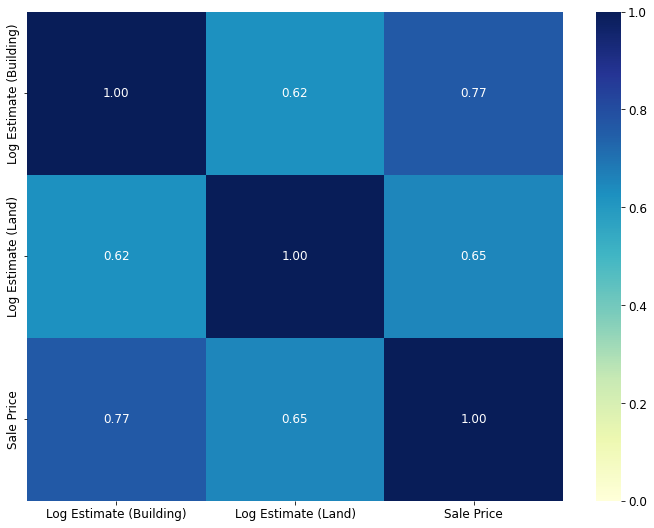

In [63]:
temp = Feature_test[["Log Estimate (Building)","Log Estimate (Land)"]]
temp["Sale Price"] = Goal
sns.heatmap(temp.corr(),vmin=0, vmax=1,cmap="YlGnBu",annot=True,fmt='.2f')  
plt.show()                                           

In [64]:
Feature_selected = Feature_test[['Log Sale Price','Log Bedrooms','Log Rooms','Log Latitude','Log Estimate (Building)','Log Estimate (Land)',
                     'Fireplaces','Log Property Class','Log Building Square Feet']]

In [65]:
Feature_selected.isnull().any()

Log Sale Price              False
Log Bedrooms                False
Log Rooms                   False
Log Latitude                False
Log Estimate (Building)     False
Log Estimate (Land)         False
Fireplaces                  False
Log Property Class          False
Log Building Square Feet    False
dtype: bool

In [66]:
temp = pd.read_csv('cook_county_contest_train.csv', index_col='Unnamed: 0')
temp = add_total_bedrooms(temp)
temp = add_total_rooms(temp)
temp = ohe_roof_material(temp)
temp = temp.drop(columns=["Roof Material","Description","Pure Market Filter","Use"])

In [67]:
temp['Property Class'].unique()

array([202, 203, 205, 208, 207, 206, 204, 278, 209], dtype=int64)

In [31]:
def ohe_fireplaces(data):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit([[0],[1],[2]])
    ohe_cols = pd.DataFrame(enc.transform(data[['Fireplaces']]).todense(), 
                           columns= enc.get_feature_names(),
                           index = data.index)
    ohe_cols = ohe_cols.rename(columns={'x0_0':'Fireplaces0','x0_1':'Fireplaces1','x0_2':'Fireplaces2'})
    data = data.join([ohe_cols])
    return data

def ohe_propertyclass(data):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit([[202],[203],[204],[205],[206],[207],[208],[209],[278]])
    ohe_cols = pd.DataFrame(enc.transform(data[['Property Class']]).todense(), 
                           columns= enc.get_feature_names(),
                           index = data.index)
    ohe_cols = ohe_cols.rename(columns={'x0_202':'Propertyclass0','x0_203':'Propertyclass1','x0_204':'Propertyclass2',
                                        'x0_205':'Propertyclass3','x0_206':'Propertyclass4','x0_207':'Propertyclass5',
                                        'x0_208':'Propertyclass6','x0_209':'Propertyclass7','x0_278':'Propertyclass8'})
    data = data.join([ohe_cols])
    return data

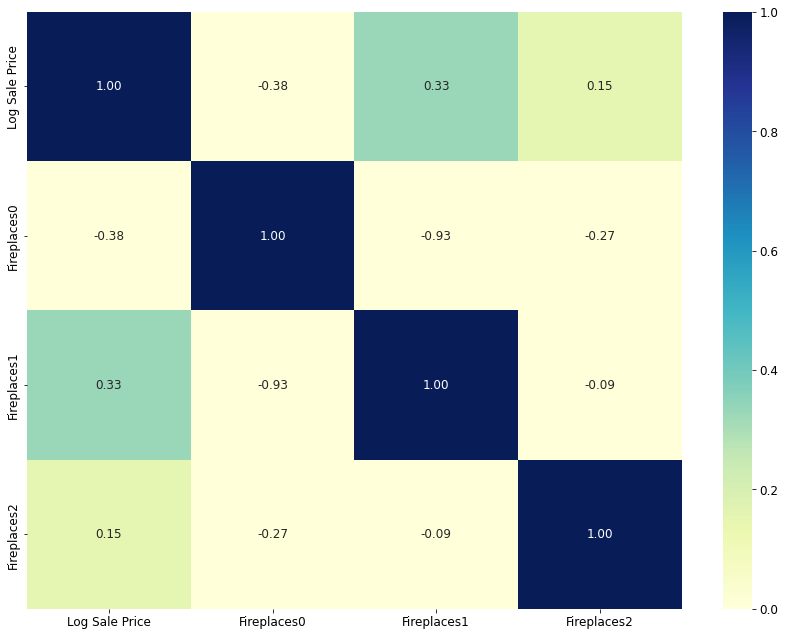

In [69]:
temp = pd.read_csv('cook_county_contest_train.csv', index_col='Unnamed: 0')
temp = ohe_fireplaces(temp)
temp = ohe_propertyclass(temp)
temp['Log Sale Price'] = np.log(temp['Sale Price'])
temp_f = temp[['Log Sale Price','Fireplaces0','Fireplaces1','Fireplaces2']]
sns.heatmap(temp_f.corr(),vmin=0, vmax=1,cmap="YlGnBu",annot=True,fmt='.2f')
plt.tight_layout()

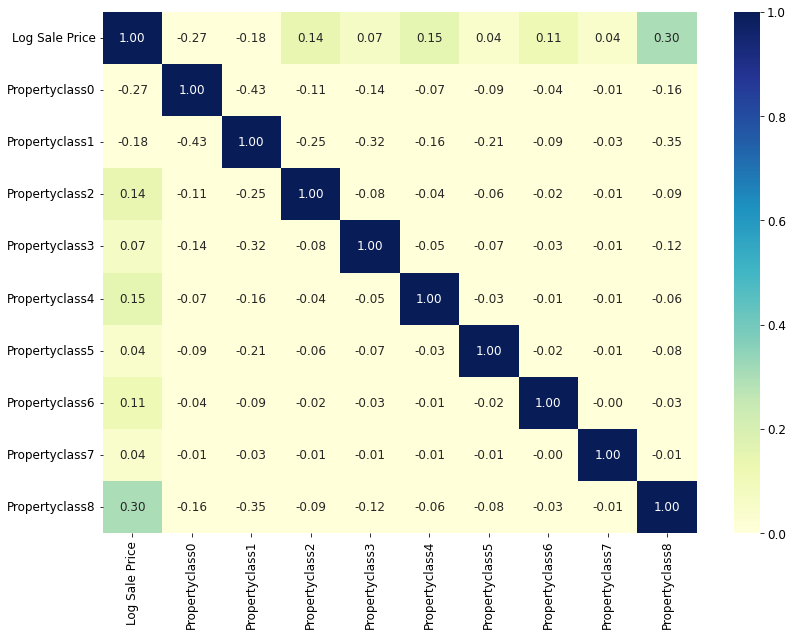

In [70]:
temp_p = temp[['Log Sale Price','Propertyclass0','Propertyclass1','Propertyclass2',
               'Propertyclass3','Propertyclass4','Propertyclass5','Propertyclass6',
               'Propertyclass7','Propertyclass8']]
sns.heatmap(temp_p.corr(),vmin=0, vmax=1,cmap="YlGnBu",annot=True,fmt='.2f')
plt.tight_layout()

Final Choice (|Cov|>0.3)

1.Log Building Square Feet
2.Rooms
3.Bedrooms
4.Latitude
5.Log Estimate Building
6.Log Estimate Land
7.Fireplaces
8.Property Class
9.Longitude

## Step 2. Setup your `process_data_fm` function

**Create your implementation of `process_data_fm` from into the following cell.**

Here are a few additional things **you should check and change to make sure your `process_data_fm` function satisfies**:
- Unlike part 1, we will not be expecting your `process_data_fm` function to return both the design matrix `X` and the observed target vector `y`; your function should now **only return X**.


In [32]:
# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of the function below. 
# Note that data will no longer have the column Sale Price in it directly, so plan your feature engineering process around that.
def process_data_fm(data):
    # Replace the following line with your own feature engineering pipeline
    X = data.copy()
    
    pipeline = [
    (add_total_bedrooms,False,False),
    (add_total_rooms,False,False),
    # (ohe_propertyclass,False,False),
    # (ohe_fireplaces,False,False),
    (replace_zero,['Bedrooms','Rooms','Latitude','Estimate (Building)','Estimate (Land)',
                     'Property Class','Building Square Feet'],False),
    (Log_all,['Bedrooms','Rooms','Latitude','Estimate (Building)','Estimate (Land)','Building Square Feet','Property Class'],False),
    (select_columns,['Log Bedrooms','Log Rooms','Log Latitude','Log Estimate (Building)','Log Estimate (Land)',
                     'Log Building Square Feet','Fireplaces','Log Property Class'
                    #  'Fireplaces0','Fireplaces1',
                    # #  'Fireplaces2',
                    #  'Propertyclass0','Propertyclass8'
                    #  'Propertyclass1','Propertyclass2','Propertyclass3','Propertyclass4',
                    #  'Propertyclass5','Propertyclass6','Propertyclass7'
                     ],False),
    ]
    
    for function, arguments, keyword_arguments in pipeline:
        if keyword_arguments and (not arguments):
            X = X.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            X = X.pipe(function, *arguments)
        else:
            X = X.pipe(function)
            
    X = X.to_numpy()
    
    return X

## Step 3. Train your model

Run the following cell to import the new set of training data to fit your model on. **You can use any regression model, the following is just an example** If your `process_data_fm` satisfies all the specified requirements, the cell should run without any error.

**As usual**, your model will predict the log-transformed sale price, and our grading will transform your predictions back to the normal vlaues.

In [ ]:

# Multiple features linear regression
train_data = pd.read_csv('cook_county_contest_train.csv', index_col='Unnamed: 0')
y_train = np.log(train_data['Sale Price'])
train_data = train_data.drop(columns=['Sale Price'])
X_train = process_data_fm(train_data)
model = lm.LinearRegression(fit_intercept=True)
###You can use other models
model.fit(X_train, y_train);

In [4]:
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

In [5]:

def train_test_split(data,percentage=0.8):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    split_point = int(data_len * percentage)
    train_idx = shuffled_indices[:split_point]
    test_idx = shuffled_indices[split_point:]
    return train_idx,test_idx

In [7]:
#Linear Regression
# Including Engineering Feature, Lasso, Ridge and Elasticnet Model
def Train_Test_RMSE(seed_num,regs):
    np.random.seed(seed_num)
    full_data = pd.read_csv('cook_county_contest_train.csv', index_col='Unnamed: 0')
    train_set = full_data.iloc[train_test_split(full_data)[0]]
    test_set = full_data.iloc[train_test_split(full_data)[1]]

    y_tr = np.log(train_set['Sale Price'])
    train_set = train_set.drop(columns=['Sale Price'])
    x_tr = process_data_fm(train_set)
    y_te = np.log(test_set['Sale Price'])
    test_set = test_set.drop(columns=['Sale Price'])
    x_te = process_data_fm(test_set)
    
    lm1 = lm.LinearRegression(fit_intercept=True)
    lm1.fit(x_tr, y_tr);
    lm2 = lm.RidgeCV(alphas=regs,fit_intercept=True)
    lm2.fit(x_tr, y_tr);
    lm3 = lm.LassoCV(alphas=regs,fit_intercept=True)
    lm3.fit(x_tr, y_tr);
    lm4 = lm.ElasticNetCV(alphas=regs,fit_intercept=True)
    lm4.fit(x_tr, y_tr);

    y_tr_predicted1 = lm1.predict(x_tr)
    y_te_predicted1 = lm1.predict(x_te)
    y_tr_predicted2 = lm2.predict(x_tr)
    y_te_predicted2 = lm2.predict(x_te)
    y_tr_predicted3 = lm3.predict(x_tr)
    y_te_predicted3 = lm3.predict(x_te)
    y_tr_predicted4 = lm4.predict(x_tr)
    y_te_predicted4 = lm4.predict(x_te)

    train_rmse1 = rmse(np.exp(y_tr_predicted1),np.exp(y_tr))
    test_rmse1 = rmse(np.exp(y_te_predicted1),np.exp(y_te))
    train_rmse2 = rmse(np.exp(y_tr_predicted2),np.exp(y_tr))
    test_rmse2 = rmse(np.exp(y_te_predicted2),np.exp(y_te))
    train_rmse3 = rmse(np.exp(y_tr_predicted3),np.exp(y_tr))
    test_rmse3 = rmse(np.exp(y_te_predicted3),np.exp(y_te))
    train_rmse4 = rmse(np.exp(y_tr_predicted4),np.exp(y_tr))
    test_rmse4 = rmse(np.exp(y_te_predicted4),np.exp(y_te))
    
    print("Using seed_number: ",seed_num)
    print("Training RMSE: ",train_rmse1)
    print("Testing RMSE: ",test_rmse1)
    print("---------------------")
    print("Ridge Training RMSE: ",train_rmse2)
    print("Ridge Testing RMSE: ",test_rmse2)
    print("---------------------")
    print("Lasso Training RMSE: ",train_rmse3)
    print("Lasso Testing RMSE: ",test_rmse3)
    print("---------------------")
    print("Elasticnet Training RMSE: ",train_rmse4)
    print("Elasticnet Testing RMSE: ",test_rmse4)
    print("---------------------")
    
    return lm1,lm2,lm3,lm4

In [ ]:
ls_alpha = []
for i in range(1,9):
    ls_alpha.extend([0.0001*i,0.001*i,0.01*i,0.1*i])
ls_alpha.append(1)
 
seed_num = np.random.randint(1000,2000)

print("Iteration begin")
lm1,lm2,lm3,lm4 = Train_Test_RMSE(seed_num,ls_alpha)
print("Iteration end")
print('\n')

Iteration begin
Using seed_number:  1980
Training RMSE:  104585.24504979589
Testing RMSE:  105819.93940450693
---------------------
Ridge Training RMSE:  104585.69572365754
Ridge Testing RMSE:  105820.48473965311
---------------------
Lasso Training RMSE:  105876.59161741914
Lasso Testing RMSE:  107445.00876936248
---------------------
Elasticnet Training RMSE:  111579.99147527403
Elasticnet Testing RMSE:  113872.75254513448
---------------------
Iteration end




In [36]:
#Xgboost model
import xgboost as xgb

rand_xgb_seed = np.random.randint(1000,2000)
np.random.seed(rand_xgb_seed)

def eval_train_test_split(tr_size=0.8,val_size=0.1):
    full_data = pd.read_csv('cook_county_contest_train.csv', index_col='Unnamed: 0')

    train_set = full_data.iloc[train_test_split(full_data,tr_size)[0]]
    test_set = full_data.iloc[train_test_split(full_data,tr_size)[1]]

    #Train and test overall Treat the test part as unknown for prediction
    train_set_all = train_set.copy()
    y_tr_xgb_all = np.log(train_set_all['Sale Price'])
    train_set_all = train_set_all.drop(columns=['Sale Price'])
    x_tr_xgb_all = process_data_fm(train_set_all)
    y_te_xgb = np.log(test_set['Sale Price'])
    test_set = test_set.drop(columns=['Sale Price'])
    x_te_xgb = process_data_fm(test_set)

    #Train_test_split the training set for xgboost validation
    train_set_tr = train_set.iloc[train_test_split(train_set,1-val_size)[0]]
    train_set_val = train_set.iloc[train_test_split(train_set,1-val_size)[1]]

    y_tr_xgb = np.log(train_set_tr['Sale Price'])
    train_set_tr = train_set_tr.drop(columns=['Sale Price'])
    x_tr_xgb = process_data_fm(train_set_tr)
    y_val = np.log(train_set_val['Sale Price'])
    train_set_val = train_set_val.drop(columns=['Sale Price'])
    x_val = process_data_fm(train_set_val)
    return x_tr_xgb,y_tr_xgb,x_te_xgb,y_te_xgb,x_val,y_val,x_tr_xgb_all,y_tr_xgb_all
    

def xgboost_test():
    x_tr,y_tr,x_te,y_te = train_test_set()
    ls = [0.25,0.26,0.27,0.28,0.29,0.3]
    test_score = []
    for x in ls:
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror',booster='dart',max_depth=8,n_estimators=300,learning_rate=x)
        test_score.append(np.mean(np.sqrt(-cross_val_score(xgb_t,x_tr,y_tr,cv=5,scoring='neg_mean_squared_error'))))
        xgb_model.fit(x_tr,y_tr,verbose=True)
        train_xgb = xgb_model.predict(x_tr)
        test_xgb = xgb_model.predict(x_te)
        train_rmse = rmse(np.exp(train_xgb),np.exp(y_tr))
        test_rmse = rmse(np.exp(test_xgb),np.exp(y_te))
        print("Training RMSE: ",train_rmse)
        print("Testing RMSE: ",test_rmse)
        print(f"Finished testing {x}")
    plt.plot(ls,test_score)
    plt.show() 


def xgboost():
    x_tr,y_tr,x_te,y_te = train_test_set()
    xgb_model = xgb.XGBRegressor(learing_rate=0.3,objective='reg:squarederror',booster='dart',max_depth=6,reg_lambda=3,n_estimators=300)
    xgb_model.fit(x_tr,y_tr,verbose=True)
    train_xgb = xgb_model.predict(x_tr)
    test_xgb = xgb_model.predict(x_te)
    train_rmse = rmse(np.exp(train_xgb),np.exp(y_tr))
    test_rmse = rmse(np.exp(test_xgb),np.exp(y_te))
    print("Training RMSE: ",train_rmse)
    print("Testing RMSE: ",test_rmse)
    return xgb_model
    

def xgboost_eval():
    x_tr_xgb,y_tr_xgb,x_te_xgb,y_te_xgb,x_val,y_val,x_tr_xgb_all,y_tr_xgb_all = eval_train_test_split(0.8,0.1)
    xgb_model = xgb.XGBRegressor(learing_rate=0.3,objective='reg:squarederror',booster='dart',max_depth=10,reg_lambda=5,n_estimators=300)
    xgb_model.fit(x_tr_xgb, y_tr_xgb,eval_metric='rmse',verbose = True, eval_set = [(x_val,y_val)],early_stopping_rounds=50)
    train_rmse_xgb = rmse(np.exp(xgb_model.predict(x_tr_xgb_all)),np.exp(y_tr_xgb_all))
    test_rmse_xgb = rmse(np.exp(xgb_model.predict(x_te_xgb)),np.exp(y_te_xgb))
    print("Xgboost Training RMSE: ",train_rmse_xgb)
    print("Xgboost Testing RMSE: ",test_rmse_xgb)
    return xgb_model
    

In [ ]:
xgboost_test()

In [7]:
def overall_RMSE(model):
    train_data = pd.read_csv('cook_county_contest_train.csv', index_col='Unnamed: 0')
    train_y = np.log(train_data['Sale Price'])
    train_data = train_data.drop(columns=['Sale Price'])
    train_x  = process_data_fm(train_data)
    all_rmse = rmse(np.exp(model.predict(train_x)),np.exp(train_y))
    print("Overall RMSE: ", all_rmse)
    return all_rmse

In [ ]:
xgb_model = xgboost_eval()
overall_RMSE(xgb_model)

In [8]:
#Set preparation
def train_test_set():
    full_data = pd.read_csv('cook_county_contest_train.csv', index_col='Unnamed: 0')
    train_set = full_data.iloc[train_test_split(full_data)[0]]
    test_set = full_data.iloc[train_test_split(full_data)[1]]
    y_tr = np.log(train_set['Sale Price'])
    train_set = train_set.drop(columns=['Sale Price'])
    x_tr = process_data_fm(train_set)
    y_te = np.log(test_set['Sale Price'])
    test_set = test_set.drop(columns=['Sale Price'])
    x_te = process_data_fm(test_set)
    return x_tr,y_tr,x_te,y_te

In [9]:
#Gradient Boosting Regressor model

from sklearn.ensemble import GradientBoostingRegressor

def GBR_Test():
    x_tr,y_tr,x_te,y_te = train_test_set()
    ls = [0.01,0.02,0.03,0.04,0.05,0.1]
    test_score = []
    for x in ls:
        GBR = GradientBoostingRegressor(n_estimators=3600, learning_rate=x,loss='huber',warm_start=True) 
        test_score.append(np.mean(np.sqrt(-cross_val_score(GBR,x_tr,y_tr,cv=5,scoring='neg_mean_squared_error'))))
        print(f"Finished testing {x}")
    plt.plot(ls,test_score)
    plt.show()   

def GBR():
    x_tr,y_tr,x_te,y_te = train_test_set()
    GBR = GradientBoostingRegressor(n_estimators=3600, learning_rate=0.03,loss='huber', random_state = 5,max_depth=10,
                                    tol=1e-3,warm_start=True,validation_fraction=0.2) 
    GBR.fit(x_tr,y_tr)
    train_GBR = GBR.predict(x_tr)
    test_GBR = GBR.predict(x_te)
    train_rmse = rmse(np.exp(train_GBR),np.exp(y_tr))
    test_rmse = rmse(np.exp(test_GBR),np.exp(y_te))
    print("Training RMSE: ",train_rmse)
    print("Testing RMSE: ",test_rmse)
    return GBR
    

In [ ]:
GBR_Test()

In [23]:
myGBR = GBR()

Training RMSE:  45311.46086956195
Testing RMSE:  55073.081747733006


In [ ]:
overall_RMSE(myGBR)

Overall RMSE:  55205.73452488048


In [10]:
def GBR_all():
    full_data = pd.read_csv('cook_county_contest_train.csv', index_col='Unnamed: 0')
    GBR = GradientBoostingRegressor(n_estimators=3600, learning_rate=0.02,loss='huber', random_state = 5,max_depth=10,
                                    tol=1e-3,warm_start=True,validation_fraction=0.2) 
    y = np.log(full_data['Sale Price'])
    full_data = full_data.drop(columns=['Sale Price'])
    x = process_data_fm(full_data)
    GBR.fit(x,y)
    
    train_GBR = GBR.predict(x)
    rmse_all = rmse(np.exp(train_GBR),np.exp(y))
    print("RMSE: ",rmse_all)
    return GBR

In [ ]:
GBR_all()

In [11]:
#Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
       
def RandomForest(max_f,n_es=100,rand_s=5):
    x_tr,y_tr,x_te,y_te = train_test_set()
    RFR = RandomForestRegressor(n_estimators=n_es,random_state=rand_s,max_features=max_f,min_samples_leaf=1,max_depth=80)
    RFR.fit(x_tr,y_tr)
    train_RFR = RFR.predict(x_tr)
    test_RFR = RFR.predict(x_te)
    train_rmse = rmse(np.exp(train_RFR),np.exp(y_tr))
    test_rmse = rmse(np.exp(test_RFR),np.exp(y_te))
    print("Training RMSE: ",train_rmse)
    print("Testing RMSE: ",test_rmse)
    return RFR

In [12]:
def RandomForest_all():
    full_data = pd.read_csv('cook_county_contest_train.csv', index_col='Unnamed: 0')
    RFR = RandomForestRegressor(n_estimators=75,random_state=10,max_features=0.25,min_samples_leaf=1,max_depth=80)
    y = np.log(full_data['Sale Price'])
    full_data = full_data.drop(columns=['Sale Price'])
    x = process_data_fm(full_data)
    RFR.fit(x,y)
    
    train_RFR = RFR.predict(x)
    rmse_all = rmse(np.exp(train_RFR),np.exp(y))
    print("RMSE: ",rmse_all)
    return RFR

In [22]:
myRFR = RandomForest(0.25,n_es=75,rand_s=10)

Training RMSE:  37055.51912969986
Testing RMSE:  48908.77521334987


In [ ]:
overall_RMSE(myRFR)

Overall RMSE:  49431.90171254075


In [ ]:
RandomForest_all()

RMSE:  37895.85031316304


RandomForestRegressor(max_depth=80, max_features=0.25, n_estimators=75,
                      random_state=10)

In [13]:
#Adaboost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

def Adaboost_test():
    x_tr,y_tr,x_te,y_te = train_test_set()
    ls = [0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5]
    test_score = []
    for x in ls:
        ada = AdaBoostRegressor(DecisionTreeRegressor(max_features=0.4,max_depth=20),random_state=10,learning_rate=x,n_estimators=175)
        test_score.append(np.mean(np.sqrt(-cross_val_score(ada,x_tr,y_tr,cv=5,scoring='neg_mean_squared_error'))))
        print(f"Finished testing {x}")
    plt.plot(ls,test_score)
    plt.show()   
        
        
def Adaboost(rand_s=10):
    x_tr,y_tr,x_te,y_te = train_test_set()
    ada = AdaBoostRegressor(DecisionTreeRegressor(max_features=0.4,max_depth=20),n_estimators=175,random_state=rand_s,learning_rate=0.05)
    ada.fit(x_tr,y_tr)
    train = ada.predict(x_tr)
    test= ada.predict(x_te)
    train_rmse = rmse(np.exp(train),np.exp(y_tr))
    test_rmse = rmse(np.exp(test),np.exp(y_te))
    print("Training RMSE: ",train_rmse)
    print("Testing RMSE: ",test_rmse)
    return ada

In [ ]:
Adaboost_test()

In [24]:
myada = Adaboost()

Training RMSE:  45380.12421169939
Testing RMSE:  54312.61411808354


In [ ]:
overall_RMSE(myada)

Overall RMSE:  54458.61794135863


In [14]:
def ada_all():
    full_data = pd.read_csv('cook_county_contest_train.csv', index_col='Unnamed: 0')
    ada = AdaBoostRegressor(DecisionTreeRegressor(max_features=0.4,max_depth=20),n_estimators=175,random_state=10,learning_rate=0.05)
    y = np.log(full_data['Sale Price'])
    full_data = full_data.drop(columns=['Sale Price'])
    x = process_data_fm(full_data)
    ada.fit(x,y)
    
    train_ada = ada.predict(x)
    rmse_all = rmse(np.exp(train_ada),np.exp(y))
    print("RMSE: ",rmse_all)
    return ada

In [ ]:
ada_all()

RMSE:  49334.46127973194


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=20,
                                                       max_features=0.4),
                  learning_rate=0.05, n_estimators=175, random_state=10)

In [63]:
#Stacking model
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split as auto_train_test_split

def prepare_stacking(model, x_train, y_train, x_test, n_folds=3):
    
    train_num, test_num = x_train.shape[0], x_test.shape[0]
    second_level_train_set = np.zeros((train_num,))
    second_level_test_set = np.zeros((test_num,))
    test_nfolds_sets = np.zeros((test_num, n_folds))
    kf = KFold(n_splits=n_folds)

    for i,(train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr, y_tr = x_train[train_index], y_train[train_index]
        x_te, y_te =  x_train[test_index], y_train[test_index]
        model.fit(x_tr, y_tr)
        second_level_train_set[test_index] = model.predict(x_te)
        test_nfolds_sets[:,i] = model.predict(x_test)
        
    second_level_test_set[:] = test_nfolds_sets.mean(axis=1)
    return second_level_train_set, second_level_test_set

def Stacking(level1_models,level2_model,nfolds=3):  
    train_data = pd.read_csv('cook_county_contest_train.csv', index_col='Unnamed: 0')
    train_y = np.log(train_data['Sale Price']).to_numpy()
    train_data = train_data.drop(columns=['Sale Price'])
    train_x  = process_data_fm(train_data)
    x_tr,x_te,y_tr,y_te = auto_train_test_split(train_x,train_y,test_size=0.2)
    
    train_set = []
    test_set = []
    i = 1
    for m in level1_models:
        x_tr_level2,x_te_level2 = prepare_stacking(m,x_tr,y_tr,x_te,n_folds=nfolds)
        train_set.append(x_tr_level2)
        test_set.append(x_te_level2)
        print(f"Model {i} Train finished!")
        i = i+1
    
    level2_train = np.concatenate([res.reshape(-1,1) for res in train_set], axis=1)
    level2_test = np.concatenate([res.reshape(-1,1) for res in test_set], axis=1)    
    level2_model.fit(level2_train, y_tr);
    
    train_rmse = rmse(np.exp(level2_model.predict(level2_train)),np.exp(y_tr))
    test_rmse= rmse(np.exp(level2_model.predict(level2_test)),np.exp(y_te))
    print("Training RMSE: ",train_rmse)
    print("Testing RMSE: ",test_rmse)

In [62]:
Ada_s = AdaBoostRegressor(DecisionTreeRegressor(max_features=0.4,max_depth=20),n_estimators=175,random_state=10,learning_rate=0.05)
RFR_s = RandomForestRegressor(n_estimators=75,random_state=10,max_features=0.25,min_samples_leaf=1,max_depth=80)
GBR_s = GradientBoostingRegressor(n_estimators=3600, learning_rate=0.03,loss='huber', random_state = 5,max_depth=10,
                                    tol=1e-3,warm_start=True,validation_fraction=0.2) 
xgb_s = xgb.XGBRegressor(learing_rate=0.3,objective='reg:squarederror',booster='dart',max_depth=6,reg_lambda=3,n_estimators=100)

Ada_t = AdaBoostRegressor(DecisionTreeRegressor(max_features=0.4))
xgb_t = xgb.XGBRegressor(objective='reg:squarederror',booster='dart')
GBR_t = GradientBoostingRegressor(learning_rate=0.03,loss='huber',tol=1e-3) 
RFR_t = RandomForestRegressor(max_features=0.25,n_estimators=75)

In [45]:
Stacking([GBR_s,RFR_s,Ada_s,xgb_s],GBR_t,nfolds=10)

Model 1 Train finished!
Model 2 Train finished!
Model 3 Train finished!
[12:19:04] WARNING: ..\src\learner.cc:541: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:19:14] WARNING: ..\src\learner.cc:541: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:19:23] WARNING: ..\src\learner.cc:541: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

In [65]:
Stacking([GBR_s,RFR_s,Ada_s,xgb_s],xgb_t,nfolds=10)

Model 1 Train finished!
Model 2 Train finished!
Model 3 Train finished!
[19:14:35] WARNING: ..\src\learner.cc:541: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:14:44] WARNING: ..\src\learner.cc:541: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:14:54] WARNING: ..\src\learner.cc:541: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

In [ ]:
Stacking([GBR_s,RFR_s,Ada_s,xgb_s],xgb_s,nfolds=10)

In [ ]:
Stacking([GBR_s,RFR_s,Ada_s,xgb_s],lm.Ridge(fit_intercept=True),nfolds=10)

In [ ]:
Stacking([GBR_s,xgb_s],lm.Ridge(fit_intercept=True),nfolds=10)

Model 1 Train finished!
[10:06:02] WARNING: ..\src\learner.cc:541: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:06:14] WARNING: ..\src\learner.cc:541: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:06:26] WARNING: ..\src\learner.cc:541: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you 

In [49]:
Stacking([GBR_s,xgb_s,Ada_s],lm.Ridge(fit_intercept=True),nfolds=10)

Model 1 Train finished!
[15:29:21] WARNING: ..\src\learner.cc:541: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:29:31] WARNING: ..\src\learner.cc:541: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:29:42] WARNING: ..\src\learner.cc:541: 
Parameters: { learing_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you 

In [ ]:
Stacking([GBR_s,Ada_s,RFR_s],lm.Ridge(fit_intercept=True),nfolds=10)

Model 1 Train finished!
Model 2 Train finished!
Model 3 Train finished!
Training RMSE:  57046.42267793019
Testing RMSE:  57555.37359686818


In [ ]:
ls_model = ['Mylm','Ridge','Lasso','Elasticnet','xgboost','GradientBoosting','RandomForest','Adaboost']
ls_rmse_m = [lm1,lm2,lm3,lm4,xgb_model,myGBR,myRFR,myada]
ls_rmse = []
for x in ls_rmse_m:
    ls_rmse.append(overall_RMSE(x))

Overall RMSE:  104698.74091754828
Overall RMSE:  104699.21414871769
Overall RMSE:  106087.54924097603
Overall RMSE:  112123.54678574052
Overall RMSE:  62884.08219441688
Overall RMSE:  55205.73452488048
Overall RMSE:  49431.90171254075
Overall RMSE:  54458.61794135863


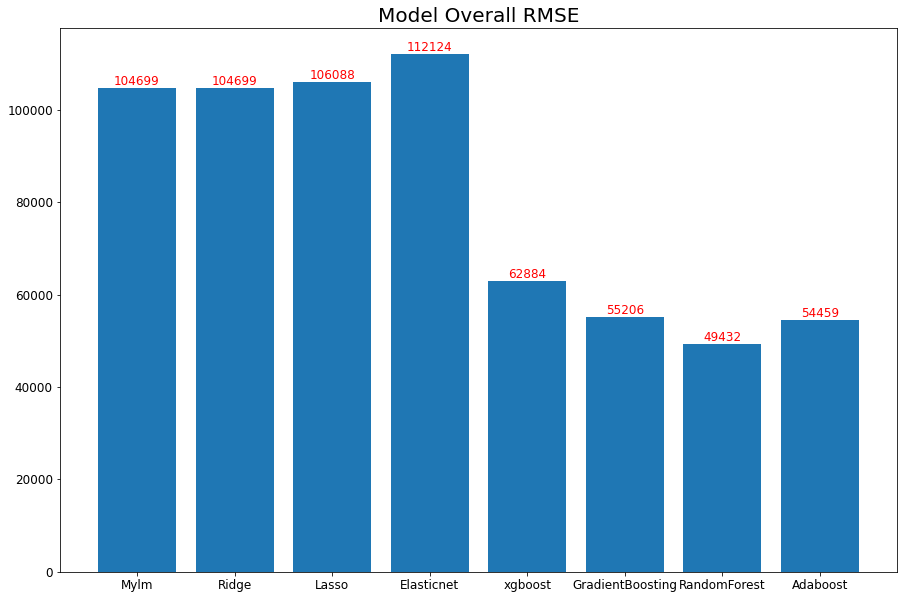

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(x=ls_model, height=ls_rmse)
ax.set_title("Model Overall RMSE", fontsize=20)
for a, b in zip(ls_model, ls_rmse):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=12,color='red')
plt.show()

Based on the above observation, I choose the Gradient Boosting Regressor as the final model.

## Step 4. Make Predictions on the Test Dataset

Run the following cell to estimate the sale price on the test dataset and export your model's predictions as a csv file called `predictions.csv`.

In [100]:
full_data = pd.read_csv('cook_county_contest_train.csv', index_col='Unnamed: 0')
tr_idx,te_idx = train_test_split(full_data)
train_set = full_data.iloc[tr_idx]
test_set = full_data.iloc[te_idx]
y_tr = np.log(train_set['Sale Price'])
train_set = train_set.drop(columns=['Sale Price'])
x_tr = process_data_fm(train_set)
y_te = np.log(test_set['Sale Price'])
test_set = test_set.drop(columns=['Sale Price'])
x_te = process_data_fm(test_set)
GBR_s.fit(x_tr,y_tr)
train_GBR = GBR_s.predict(x_tr)
test_GBR = GBR_s.predict(x_te)
train_rmse = rmse(np.exp(train_GBR),np.exp(y_tr))
test_rmse = rmse(np.exp(test_GBR),np.exp(y_te))
print("Training RMSE: ",train_rmse)
print("Testing RMSE: ",test_rmse)

Training RMSE:  57148.22242687859
Testing RMSE:  57414.935558916324


In [101]:
test_data = pd.read_csv('cook_county_contest_test.csv', index_col='Unnamed: 0')
X_test = process_data_fm(test_data)
overall_RMSE(GBR_s)
y_test_predicted = np.exp(GBR_s.predict(X_test))
predictions = pd.DataFrame({'Sale Price': y_test_predicted})
predictions.to_csv('predictions.csv')
print('Your predictions have been exported as predictions.csv. Please download the file and submit it to Canvas. ')

Overall RMSE:  56894.42839562827
Your predictions have been exported as predictions.csv. Please download the file and submit it to Canvas. 
